In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, average_precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold

In [ ]:
#Read in the pre-op, intra-op, stiffness, and outcomes data
preop = pd.read_csv('/content/drive/MyDrive/PCM_Classification/pre-op.csv')
intraop = pd.read_csv('/content/drive/MyDrive/PCM_Classification/intra-op.csv')
stiffness = pd.read_excel('/content/drive/MyDrive/PCM_Classification/stiffness_labeled.xlsx')

In [ ]:
# merged the pre-opp and intra-op data with the Stiffness labelled based on study number remove any rows that don't appear in stiffness_labelled drop these columns from pre-op procedure,surgeon,Other surgeon,surgdate,mv path,mv severeity,TVR added

merged_data = pd.merge(pd.merge(preop, intraop, on='study#', how='inner'), stiffness, on='study#', how='inner')
merged_data = merged_data.drop(columns=['procedure', 'surgeon', 'Other surgeon', 'surgdate', 'mv path', 'mv severeity', 'TVR added', 'MRN',])

#% increase in Stiffness as a feature, drop the original pre-bypass and post-bypass stiffness columns
#merged_data['% Increase Stiffness'] = ((merged_data['Post-bypass Stiffness'] - merged_data['Pre-bypass Stiffness']) / merged_data['Pre-bypass Stiffness']) * 100
#merged_data = merged_data.drop(columns=['Pre-bypass Stiffness', 'Post-bypass Stiffness'])

print(merged_data.head())


   study#  age  sex  race  ethnicity  heightcm  weightkg  phenylmcg  ephedmg  \
0       1   65    2     5          2     160.0      62.1      100.0      0.0   
1       2   63    1     5          2     177.8      82.8       50.0     40.0   
2       3   71    1     5          2     175.3      70.3     4400.0      0.0   
3       4   61    1     5          2     180.3      99.8     2200.0      0.0   
4       5   76    1     5          2     175.3      93.6     4350.0     25.0   

   epimg  ...  vasou  vasomin  vasomax  ntgtotaldose  ntgmin  ntgmax  \
0  0.000  ...    0.0      0.0      0.0          0.00       0       0   
1  0.075  ...    0.0      0.0      0.0          0.00       0       0   
2  0.385  ...    2.0      0.0      0.0         50.00       0       0   
3  0.000  ...    0.0      0.0      0.0          0.00       0       0   
4  0.390  ...    1.0      0.0      0.0        720.06      30      30   

   Pre-bypass Stiffness  Post-bypass Stiffness  iculengthofstay_hours  >48h  
0       

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

features = merged_data  # Features used for cluster

# Normalization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
# K-means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# 将聚类结果添加到原数据中
merged_data['Cluster'] = clusters

# 可视化聚类结果
plt.figure(figsize=(10, 6))
plt.scatter(data['feature1'], data['feature2'], c=data['Cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()

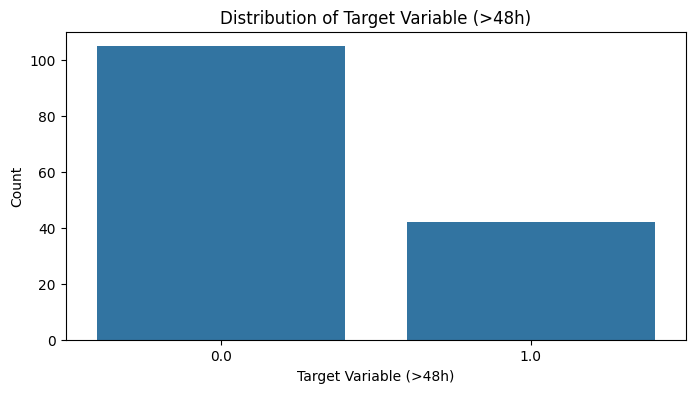

In [ ]:
target_column = '>48h'

# Plotting the distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=target_column, data=merged_data)
plt.title('Distribution of Target Variable (>48h)')
plt.xlabel('Target Variable (>48h)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Calculating Q1 and Q3
Q1 = merged_data['iculengthofstay_hours'].quantile(0.25)
Q3 = merged_data['iculengthofstay_hours'].quantile(0.75)
IQR = Q3 - Q1

# Defining bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering the DataFrame to remove outliers
filtered_data = merged_data[(merged_data['iculengthofstay_hours'] >= lower_bound) & (merged_data['iculengthofstay_hours'] <= upper_bound)]

print(f"Original data size: {merged_data.shape[0]}")
print(f"Filtered data size: {filtered_data.shape[0]}")

Original data size: 147
Filtered data size: 135


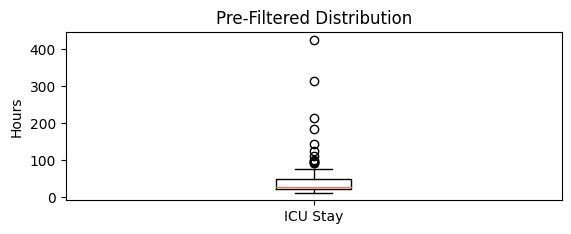

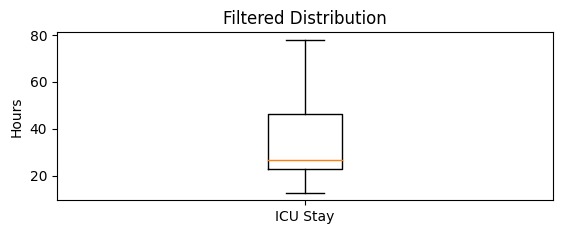

In [ ]:
# Plotting 'iculengthofstay_hours' to identify outliers
plt.subplot(2, 1, 1)
plt.boxplot(merged_data['iculengthofstay_hours'])
plt.title('Pre-Filtered Distribution')
plt.ylabel('Hours')
plt.xticks([1], ['ICU Stay'])
plt.show()

plt.subplot(2, 1, 2)
plt.boxplot(filtered_data['iculengthofstay_hours'])
plt.title('Filtered Distribution')
plt.ylabel('Hours')
plt.xticks([1], ['ICU Stay'])
plt.show()

In [ ]:
# Drop the study number column and iculengthofstay_hours column
merged_data_clf = filtered_data.drop(columns=['study#', '>48h'])

# Separate features (X) and target (y)
X = merged_data_clf.drop('iculengthofstay_hours', axis=1)
y = merged_data_clf['iculengthofstay_hours']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Number of splits for KFold
n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
#Hyperparameter Tuning using Grid Search
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

def svr_objective(trial):
    C = trial.suggest_float('C', 0.1, 100.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    epsilon = trial.suggest_float('epsilon', 0.01, 1.0)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    svr_obj = SVR(C=C, kernel=kernel, gamma=gamma, epsilon=epsilon)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', svr_obj)
    ])

    score = cross_val_score(pipeline, X, y, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
    mse = score.mean()
    return mse


svr_study = optuna.create_study(direction='maximize')
svr_study.optimize(svr_objective, n_trials=100)
print("Best parameters for SVR: ", svr_study.best_params)

def lr_objective(trial):
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])

    lr_obj = LinearRegression(fit_intercept=fit_intercept)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', lr_obj)
    ])

    score = cross_val_score(pipeline, X, y, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
    mse = score.mean()
    return mse

lr_study = optuna.create_study(direction='maximize')
lr_study.optimize(lr_objective, n_trials=100)
print("Best parameters for Linear Regression: ", lr_study.best_params)

def enet_objective(trial):
    alpha = trial.suggest_float('alpha', 1e-3, 10.0)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    enet_obj = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter,random_state=42)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', enet_obj)
    ])

    score = cross_val_score(pipeline, X, y, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
    mse = score.mean()
    return mse


enet_study = optuna.create_study(direction='maximize')
enet_study.optimize(enet_objective, n_trials=100)
print("Best parameters for ElasticNet: ", enet_study.best_params)


[I 2024-04-22 14:24:41,319] A new study created in memory with name: no-name-2385bf0d-6d58-4d70-a294-3a0a4be4b814
[I 2024-04-22 14:24:41,374] Trial 0 finished with value: -222209803378.43774 and parameters: {'C': 52.090681089531856, 'kernel': 'poly', 'epsilon': 0.6341530988429886, 'gamma': 'scale'}. Best is trial 0 with value: -222209803378.43774.
[I 2024-04-22 14:24:41,419] Trial 1 finished with value: -1222.6438570699572 and parameters: {'C': 32.74841462032587, 'kernel': 'sigmoid', 'epsilon': 0.7808284151968555, 'gamma': 'scale'}. Best is trial 1 with value: -1222.6438570699572.
[I 2024-04-22 14:24:41,472] Trial 2 finished with value: -354.52209608301604 and parameters: {'C': 64.8141811638911, 'kernel': 'rbf', 'epsilon': 0.15912459872239074, 'gamma': 'auto'}. Best is trial 2 with value: -354.52209608301604.
[I 2024-04-22 14:24:41,514] Trial 3 finished with value: -3032.56369672558 and parameters: {'C': 40.860863426930194, 'kernel': 'sigmoid', 'epsilon': 0.028092095197400614, 'gamma':

Best parameters for SVR:  {'C': 12.26979812221925, 'kernel': 'rbf', 'epsilon': 0.8719276717658493, 'gamma': 'auto'}


[I 2024-04-22 14:24:47,476] Trial 4 finished with value: -18269.3768511961 and parameters: {'fit_intercept': False}. Best is trial 3 with value: -17959.203831886127.
[I 2024-04-22 14:24:47,531] Trial 5 finished with value: -18269.3768511961 and parameters: {'fit_intercept': False}. Best is trial 3 with value: -17959.203831886127.
[I 2024-04-22 14:24:47,570] Trial 6 finished with value: -17959.203831886127 and parameters: {'fit_intercept': True}. Best is trial 3 with value: -17959.203831886127.
[I 2024-04-22 14:24:47,623] Trial 7 finished with value: -17959.203831886127 and parameters: {'fit_intercept': True}. Best is trial 3 with value: -17959.203831886127.
[I 2024-04-22 14:24:47,675] Trial 8 finished with value: -17959.203831886127 and parameters: {'fit_intercept': True}. Best is trial 3 with value: -17959.203831886127.
[I 2024-04-22 14:24:47,732] Trial 9 finished with value: -17959.203831886127 and parameters: {'fit_intercept': True}. Best is trial 3 with value: -17959.203831886127.


Best parameters for Linear Regression:  {'fit_intercept': True}


[I 2024-04-22 14:24:53,335] Trial 4 finished with value: -263.755102563058 and parameters: {'alpha': 2.180735196780261, 'l1_ratio': 0.7626365675701531, 'max_iter': 821}. Best is trial 4 with value: -263.755102563058.
[I 2024-04-22 14:24:53,378] Trial 5 finished with value: -271.33051128788003 and parameters: {'alpha': 9.36333951540367, 'l1_ratio': 0.6266736535793486, 'max_iter': 623}. Best is trial 4 with value: -263.755102563058.
[I 2024-04-22 14:24:53,420] Trial 6 finished with value: -271.3962815132989 and parameters: {'alpha': 8.049853161689724, 'l1_ratio': 0.6752632504669527, 'max_iter': 172}. Best is trial 4 with value: -263.755102563058.
[I 2024-04-22 14:24:53,461] Trial 7 finished with value: -266.6927934262376 and parameters: {'alpha': 7.541962232126789, 'l1_ratio': 0.2137601267449919, 'max_iter': 353}. Best is trial 4 with value: -263.755102563058.
[I 2024-04-22 14:24:53,514] Trial 8 finished with value: -505.198188808188 and parameters: {'alpha': 1.455319206843235, 'l1_ratio

Best parameters for ElasticNet:  {'alpha': 2.3982280094927897, 'l1_ratio': 0.48859603478638336, 'max_iter': 997}


In [ ]:
models = {
    'SVR': SVR(C=12.212042561471991, kernel='rbf', epsilon=0.8746358737064025, gamma='auto'),
    'Linear_reg': LinearRegression(fit_intercept=True),
    'ElasticNet': ElasticNet(alpha=2.398897266436479, l1_ratio=0.488504671389891, max_iter=997, random_state=42),
}

In [ ]:
def train_and_evaluate_model(regressor, X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', regressor)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    return y_pred

In [ ]:
results = {name: {'y_test': [], 'y_pred': []} for name, _ in models.items()}

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for name, reg in models.items():
        y_pred = train_and_evaluate_model(reg, X_train, y_train, X_test, y_test)
        results[name]['y_test'].extend(y_test)
        results[name]['y_pred'].extend(y_pred)

# After all folds, generate and print regression metrics for each regressor
for name, data in results.items():
    print(f"Results for {name}:")
    mse = mean_squared_error(data['y_test'], data['y_pred'])
    rmse = np.sqrt(mse)
    r2 = r2_score(data['y_test'], data['y_pred'])
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")

    print("---------------------------------------------------------")

Results for SVR:
Mean Squared Error: 311.18
Root Mean Squared Error: 17.64
R-squared: -0.17
---------------------------------------------------------
Results for Linear_reg:
Mean Squared Error: 347.81
Root Mean Squared Error: 18.65
R-squared: -0.31
---------------------------------------------------------
Results for ElasticNet:
Mean Squared Error: 256.67
Root Mean Squared Error: 16.02
R-squared: 0.03
---------------------------------------------------------


Plotting results for SVR


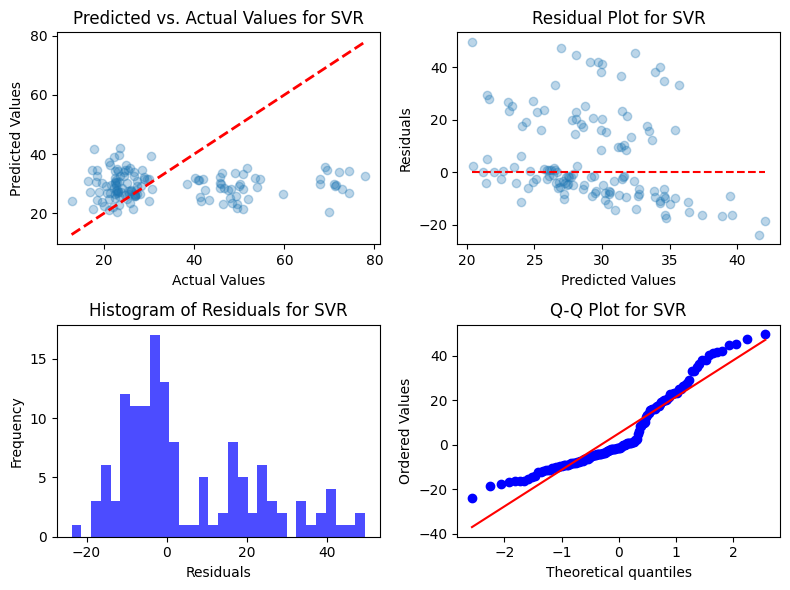

Plotting results for Linear_reg


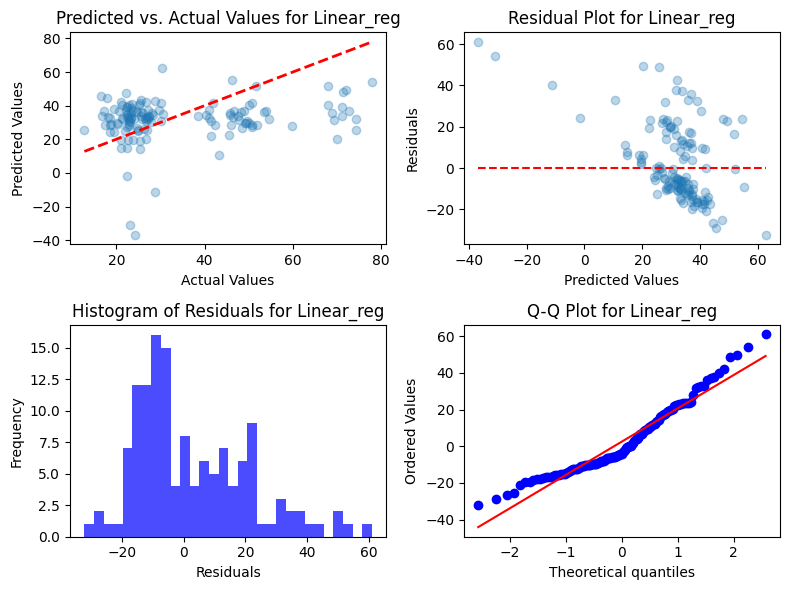

Plotting results for ElasticNet


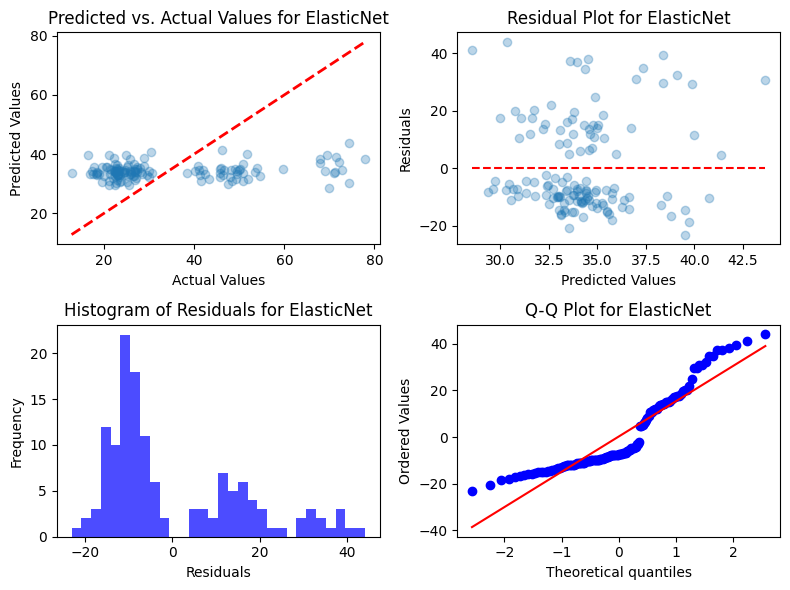

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def plot_performance(results):
    # Iterate over each model
    for name, data in results.items():
        print(f"Plotting results for {name}")
        y_true = np.array(data['y_test'])
        y_pred = np.array(data['y_pred'])

        # Calculating residuals
        residuals = y_true - y_pred

        # Plotting
        plt.figure(figsize=(8, 6))

        # Scatter plot of Predicted vs. Actual
        plt.subplot(2, 2, 1)
        plt.scatter(y_true, y_pred, alpha=0.3)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predicted vs. Actual Values for {name}')

        # Residual Plot
        plt.subplot(2, 2, 2)
        plt.scatter(y_pred, residuals, alpha=0.3)
        plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'Residual Plot for {name}')

        # Histogram of Residuals
        plt.subplot(2, 2, 3)
        plt.hist(residuals, bins=30, color='blue', alpha=0.7)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of Residuals for {name}')

        # Q-Q Plot
        plt.subplot(2, 2, 4)
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title(f'Q-Q Plot for {name}')

        plt.tight_layout()
        plt.show()

plot_performance(results)

In [ ]:
##TO DO: Permutation Importance